In [1]:
%load_ext autoreload

In [2]:
import os
import torch
import parkinson
import sys

import pandas as pd
import numpy as np

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pycatch22 import catch22_all

In [3]:
print(os.listdir('../'))
sys.path.append('../')

['README.md', 'pyproject.toml', 'outputs', 'parkinson', 'Makefile', 'poetry.toml', 'data', 'requirements.txt', 'weights', '.git', 'notebooks', '.venv', '.gitignore', 'poetry.lock']


In [4]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 32
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001
CORR_METHOD = "pearson"  # método de matriz de correlação: sliding_window, pearson...(no graph.py)
SAVE_PATH = '../outputs/1.3_catch22'

# Processamento dos dados

In [5]:
# lendo os arquivos de dados
print('Started file reading...')
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')
print('File reading completed.')

# selecionando as colunas de atlas AAL3, o atlas de conectividade cerebral
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

# Transformando os dados selecionados em séries temporais (shape = [n_pacientes, n_canais, n_observações]).
control_ts_data = parkinson.utils.data.df_to_timeseries(control_atlas_data)
parkinson_ts_data = parkinson.utils.data.df_to_timeseries(parkinson_atlas_data)
prodomal_ts_data = parkinson.utils.data.df_to_timeseries(prodomal_atlas_data)

# Misturando pacientes Controle/Parkinson e trocando valores NaN por zero.
X = parkinson.utils.data.concatenate_data(parkinson_ts_data, control_ts_data, prodomal_ts_data)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
X, y = parkinson.utils.data.filter_data(X, y)

Started file reading...


100%|██████████| 188/188 [00:07<00:00, 25.79it/s]


File reading completed.


In [6]:
def extract_catch22_features(X):
    n_samples, n_channels, time = X.shape
    X_feats = np.zeros((n_samples, n_channels, 22))
    for i in range(n_samples):
        for j in range(n_channels):
            feats = catch22_all(X[i, j])['values']
            X_feats[i, j, :] = feats
    return X_feats

print("Extracting catch22 features...")
X = extract_catch22_features(X)
print("Ended extraction.")

mask_valid = ~np.isnan(X).any(axis=(1, 2))
X = X[mask_valid]
y = y[mask_valid]

# Flatten para normalizar (n amostras, n_canais*22)
X_flat = X.reshape(X.shape[0], -1)

# Normalização
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

# Se quiser manter o shape original (n_amostras, n_canais, 22)
X = X_flat.reshape(X.shape[0], X.shape[1], X.shape[2])

# # Flatten X para (n_samples, n_features)
# X_flat = X.reshape(X.shape[0], -1)

Extracting catch22 features...
Ended extraction.


In [7]:
n_people, n_leads, n_features = X.shape

# Get the indices of the upper triangle (excluding the diagonal)
tri_upper_idx = np.triu_indices(n_leads, k=1)  # k=1 excludes the diagonal

# Preallocate a numpy array: (404 people, N upper triangle elements per person)
n_pairs = len(tri_upper_idx[0])  # number of upper triangle elements
correlation_vectors = np.zeros((n_people, n_pairs))

for i in range(n_people):
    # (166, 22)
    person_data = X[i]

    # Correlation matrix (166 x 166)
    corr = np.corrcoef(person_data, rowvar=True)

    # Store only upper triangle (excluding diagonal)
    correlation_vectors[i] = corr[tri_upper_idx]

In [8]:
X = correlation_vectors

In [9]:
# Separando os dados em 80% treino das 2 etapas e 20% teste.
X_train_2etapas, X_test_final, y_train_2etapas, y_test_final = train_test_split(X, y, test_size=0.1, random_state=RDN, stratify=y, shuffle=True)

# Separando os dados da primeira etapa (Control vs Não Saudáveis).
X_1step = X_train_2etapas
y_1step = np.where(y_train_2etapas == 2, 1, y_train_2etapas)
X_1step_trainval, X_1step_test, y_1step_trainval, y_1step_test = train_test_split(X_1step, y_1step, test_size=0.1, random_state=RDN, stratify=y_train_2etapas, shuffle=True)
X_1step_train, X_1step_val, y_1step_train, y_1step_val = train_test_split(X_1step_trainval, y_1step_trainval, test_size=1/9, random_state=RDN, stratify=y_1step_trainval, shuffle=True)

# Separando os dados da segunda etapa (Parkinson vs Prodomals).
X_2step = X_train_2etapas[y_train_2etapas != 0]
y_2step = y_train_2etapas[y_train_2etapas != 0]
y_2step = np.where(y_2step == 2, 0, y_2step)
X_2step_trainval, X_2step_test, y_2step_trainval, y_2step_test = train_test_split(X_2step, y_2step, test_size=0.1, random_state=RDN, stratify=y_2step, shuffle=True)
X_2step_train, X_2step_val, y_2step_train, y_2step_val = train_test_split(X_2step_trainval, y_2step_trainval, test_size=1/9, random_state=RDN, stratify=y_2step_trainval, shuffle=True)

In [10]:
X_1step_train.shape

(289, 13695)

In [11]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Contagem de amostras por classe
counts = np.bincount(y_1step_train)
minority_class = np.argmin(counts)
majority_class = np.argmax(counts)

# Número desejado de amostras para a classe majoritária
n_minority = counts[minority_class]
n_majority_desired = int(1 * n_minority)

# Define a estratégia de amostragem com a razão desejada
sampling_strategy = {
    minority_class: n_minority,
    majority_class: n_majority_desired
}

# Aplicando o RandomUnderSampler com a estratégia customizada
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=RDN)
X_1step_train_resampled, y_1step_train_resampled = rus.fit_resample(X_1step_train, y_1step_train)

# Checando as novas distribuições
print('Distribuição original:', {int(k): int(v) for k, v in zip(*np.unique(y_1step_train, return_counts=True))})
print('Distribuição após undersampling:', {int(k): int(v) for k, v in zip(*np.unique(y_1step_train_resampled, return_counts=True))})

Distribuição original: {0: 47, 1: 242}
Distribuição após undersampling: {0: 47, 1: 47}


In [12]:
# Criando DataLoader
test_final_loader = parkinson.utils.data.get_torch_dataloader(X_test_final, y_test_final, batch_size=BATCH_SIZE)

train_1step_loader = parkinson.utils.data.get_torch_dataloader(X_1step_train, y_1step_train, batch_size=BATCH_SIZE)
val_1step_loader = parkinson.utils.data.get_torch_dataloader(X_1step_val, y_1step_val, batch_size=BATCH_SIZE)
test_1step_loader = parkinson.utils.data.get_torch_dataloader(X_1step_test, y_1step_test, batch_size=BATCH_SIZE)

train_2step_loader = parkinson.utils.data.get_torch_dataloader(X_2step_train, y_2step_train, batch_size=BATCH_SIZE)
val_2step_loader = parkinson.utils.data.get_torch_dataloader(X_2step_val, y_2step_val, batch_size=BATCH_SIZE)
test_2step_loader = parkinson.utils.data.get_torch_dataloader(X_2step_test, y_2step_test, batch_size=BATCH_SIZE)

# Treinamento Control vs Não Saudáveis (1 step)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customMLP(input_dim=X_1step_train.shape[1], hidden_dim=16, output_dim=N_CLASSES)

model.train()
criterion = nn.CrossEntropyLoss()

out1 = parkinson.utils.train.train(model, train_1step_loader, val_1step_loader, device, N_EPOCHS, PATIENCE, LR, "../weights/1.3_catch22/1step")

metrics1 = parkinson.utils.train.evaluate(model, test_1step_loader, device, "../weights/1.3_catch22/1step")

train-loss: 0.0943  train-acc: 1.0000 | val-loss: 0.5367  val-acc: 0.8378:  22%|██▏       | 44/200 [00:20<01:14,  2.10it/s]

Early stopping at epoch 45



/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Treinamento Parkinson vs Prodomals (2 step)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customMLP(input_dim=X_2step_train.shape[1], hidden_dim=16, output_dim=N_CLASSES)

model.train()
criterion = nn.CrossEntropyLoss()

out2 = parkinson.utils.train.train(model, train_2step_loader, val_2step_loader, device, N_EPOCHS, PATIENCE, LR, "../weights/1.3_catch22/2step")

metrics2 = parkinson.utils.train.evaluate(model, test_2step_loader, device, "../weights/1.3_catch22/2step")

train-loss: 0.1584  train-acc: 0.9917 | val-loss: 0.6951  val-acc: 0.5161:  13%|█▎        | 26/200 [00:11<01:14,  2.34it/s]

Early stopping at epoch 27


# Análise dos resultados

## 1 Step

 Acurácia       F1  Precisão   Recall
 0.837838 0.763911  0.701972 0.837838


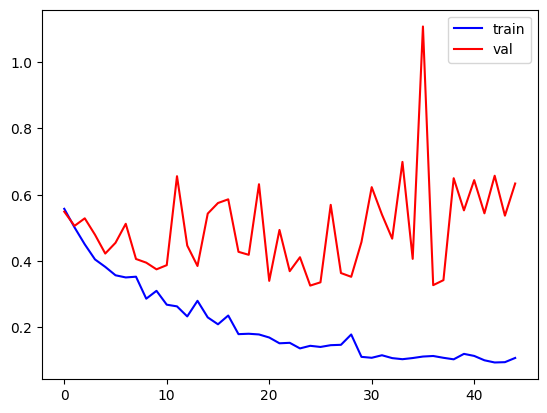

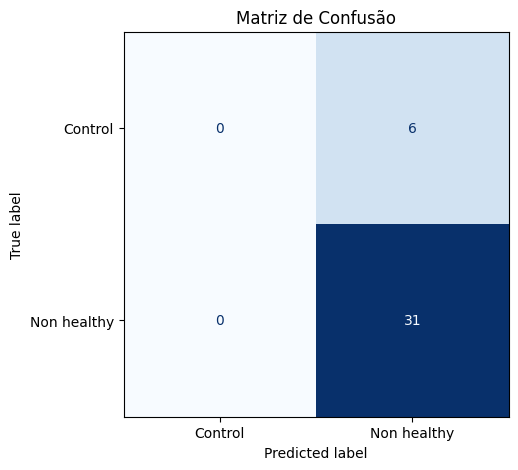

In [15]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics1)
fig_loss = parkinson.utils.results.plot_losses(out1['train_loss'],out1['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics1['preds'], metrics1['labels'], class_names=['Control','Non healthy'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/1step/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/1step/confusion_matrix.png", bbox_inches='tight')

## 2 Step

 Acurácia       F1  Precisão   Recall
 0.548387 0.474259  0.530466 0.548387


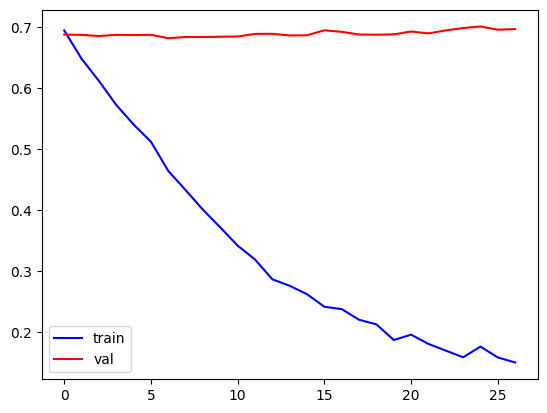

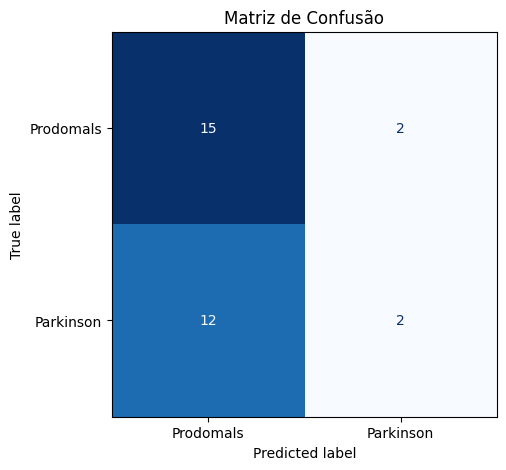

In [16]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics2)
fig_loss = parkinson.utils.results.plot_losses(out2['train_loss'],out2['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics2['preds'], metrics2['labels'], class_names=['Prodomals','Parkinson'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/2step/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/2step/confusion_matrix.png", bbox_inches='tight')

# Treinamento Modelo Final

In [17]:
model1 = parkinson.NetworkModels.customMLP(X_1step_train.shape[1], 16, N_CLASSES).to(device)
model1.load_state_dict(torch.load("../weights/1.3_catch22/1step/best_model.pth", map_location=device))

model2 = parkinson.NetworkModels.customMLP(X_2step_train.shape[1], 16, N_CLASSES).to(device)
model2.load_state_dict(torch.load("../weights/1.3_catch22/2step/best_model.pth", map_location=device))

<All keys matched successfully>

In [18]:
all_preds = []
all_true = []

model1.eval()
model2.eval()
with torch.no_grad():
    for X_batch, y_batch in test_final_loader:
        for i in range(X_batch.shape[0]):
            x = X_batch[i].unsqueeze(0).to(device)
            y_true = y_batch[i].item()
            all_true.append(y_true)
            output1 = model1(x)
            pred1 = output1.argmax(dim=1).item()
            if pred1 == 0:
                all_preds.append(0)  # Control
            else:
                output2 = model2(x)
                pred2 = output2.argmax(dim=1).item()
                if pred2 == 1:
                    all_preds.append(1)  # Parkinson
                else:
                    all_preds.append(2)  # Prodomal

   Acurácia        F1  Precisão    Recall
0  0.414634  0.276423  0.207317  0.414634


/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


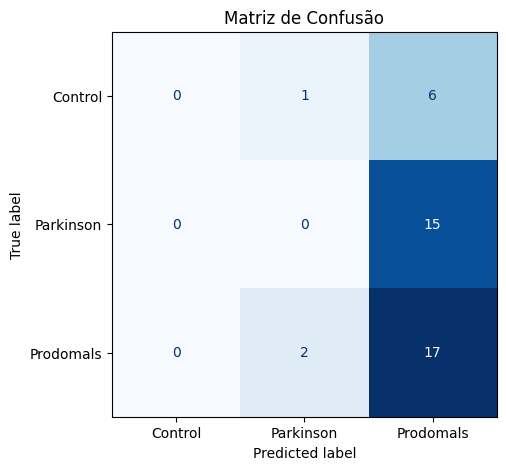

In [19]:
# Calculando métricas gerais para o modelo final (3 classes)
df_metrics = pd.DataFrame({
    'Acurácia': [accuracy_score(all_true, all_preds)],
    'F1': [f1_score(all_true, all_preds, average='weighted')],
    'Precisão': [precision_score(all_true, all_preds, average='weighted')],
    'Recall': [recall_score(all_true, all_preds, average='weighted')]
})
print(df_metrics)

# Criando e plotando os resultados.
fig_cf = parkinson.utils.results.plot_confusion_matrix(all_preds, all_true, class_names=['Control','Parkinson', 'Prodomals'])
fig_cf.show()

# Salvando as figuras.
fig_cf.savefig(f"{SAVE_PATH}/confusion_matrix.png", bbox_inches='tight')